# Travelling Salesman Problem

El problema consiste en modelar un problema de viajante de comercio con
resolución aproximada mediante las metaheurísticas *Enfriamiento Simulado*
y *Búsqueda Tabú*

In [93]:
%matplotlib inline

In [94]:
from numpy import *
from random import *
from math import exp, log
from copy import deepcopy
from itertools import cycle
import matplotlib as matplotlib
import re

Definimos una solución como un objeto `Route`.

> **`Route`**
>> **`__init__`**: 
>>> Recibe en su construcción una permutación y una matriz de distancias

>> **`permutation`**: 
>>> Contiene la permutación de ciudades en el orden en que se visitan

>> **`cost`**: 
>>> Devuelve el coste de la permutación

>> **`update_cost`**: 
>>> Recalcula el coste de la permutación

>> **`change_positions`**: 
>>> Método que intercambia dos ciudades de la permutación

>> **`change_edges`**: 
>>> Método que permite intercambiar dos arcos de la permutación dados por su índice, donde si la permutación es [1,3,4], el arco 0-ésimo es (4,1) y el arco 1-ésimo es (1,3)

>> **`get_edges`**: 
>>> Método que devuelve los arcos como tuplas de las ciudades que unen


In [95]:
class Route:
        
        def __init__(self, permutation, dist):
            self.permutation = deepcopy(array(permutation))
            self.dist = array(dist)
            self.update_cost()

        """Calculates cuadratic cost"""
        def update_cost(self):
            pairs = self.get_edges()
            self.cost = sum([self.dist[x,y] for (x,y) in pairs])
        
        def change_positions(self,i,j):
            # Intercambia dos ciudades del grafo
            self.permutation[i], self.permutation[j] = self.permutation[j], self.permutation[i]
            self.update_cost()
            
        def change_edges(self,i,j):
            # Intercambia dos aristas del grafo
            i,j = min(i,j), max(i,j)
            
            rev = self.permutation[i:j]
            rev = rev[::-1]
            self.permutation[i:j] = rev
            self.update_cost()
        
        def get_edges(self):
            shifted = append(self.permutation[1:], [self.permutation[0]])
            pairs = zip(self.permutation, shifted)
            return(pairs)
            

Implementación de la clase `TSP` que albergará los datos del problema

> **`TSP`**

>> **`__init__`**: 
>>> Se le pasa como parámetro `file`, un nombre de un fichero *.tsp* que se encuentre dentro del directorio en que trabajamos. Hace uso de la función auxiliar **`__read`** para leer el fichero

>> **`print_solution`**: 
>>> Recibe un objeto de la clase `Route`, `solution`, y hace un plot de la permutación que en él se representa

>> **`simulated_annealing`**: 
>>> Resuelve el problema del viajante de comercio empleando un enfriamiento simulado con esquema geométrico, con operador de generación de vecino 2-opt de arcos, y selección de temperatura inicial a:
 $$T_0 = \frac{\mu}{-log(\phi)} \cdot Cost(S_0)  $$
>>> Esto es, un factor $\mu$ de probabilidad de tomar una solución $\phi$ veces peor que la inicial $S_0$

>>> **`n_iter`**: Número de evaluaciones que se hacen de la función objetivo

>>> **`max_exitos`**: Número de máximo de mejoras encontradas en un vecindario

>>> **`max_vecinos`**: Número de vecinos que se generarán en cada exploración de vecindario

>>> **`alpha`**: factor de descenso de la media geométrica $T_k = \alpha \cdot T_{k-1}$

>>> **`mu`**

>>> **`phi`**

>> **`__make_permutation`**: 
>>> Devuelve una construcción *greedy* que va seleccionando a cada paso, de los arcos válidos (aquellos cuyo origen o destino no ha sido seleccionado aún) los menos usados en soluciones, lo cuál se mide con una matriz de frecuencias **`edge_freq`**, que contiene el número de veces que cada arco ha salido en soluciones anteriores. Esta matriz **`edge_freq`** es simétrica.


>> **`tabu_search`**: 
>>> Resuelve el problema del viajante de comercio empleando una búsqueda tabú con memoria de corto y largo plazo.

>>> La memoria de largo plazo **`edge_freq`** es una matriz que almacena las veces que un arco `(p,q)` ha salido en un vecino bueno del vecindario (uno que mejorase al mejor hasta el momento **`best_neighbour`**).

>>> Cuando se produce la reinicialización (con probabilidad **`1-prob_intensificacion`** cada vez que se alcanza **`limit_restart`** de vecinos sin elementos tabú que no mejoran a **`best_neighbour`**), se resetean todos los valores de la memoria de largo plazo a 0.

>>> La intensificación reinicia la búsqueda a la mejor solución encontrada **`best_solution`** con una probabilidad de **`prob_intensificacion`** cada vez que se llega un número **`limit_restart`** de vecinos sin elementos tabú que no mejoran a **`best_neighbour`**.

>>> El operador de vecino empleado ha sido 2-opt de arcos.

>>> **`max_iter`**: Número de vecinos que se generan

>>> **`max_vecinos`**: Número de vecinos que se generarán en cada exploración de vecindario

>>> **`limit_restart`**: Número de evaluaciones de la función objetivo que no han mejorado

>>> **`tabu_tenencia`**: Tamaño de la **`tabu_list`** que contiene los movimientos 2-opt más recientes

>>> **`aspiration_tol`**: Criterio de aspiración. Da la tolerancia en coste en el intervalo $[0,1]$ frente a la mejor solución obtenida hasta el momento

>>> **`prob_intensificacion`**: Probabilidad con la que tras un número **`limit_restart`** de vecinos que no mejoran, se intensificará la búsqueda sobre la mejor solución hasta el momento.

In [298]:
class TSP:
    def __init__(self, file):
        self.points = array(self.__read(file))
        self.dist = sqrt(
            [
                [dot(subtract(x,y),subtract(x,y)) for x in self.points] 
                for y in self.points
            ])    
    
    
    
    def __read (self, file):  
        f = open(file, 'r')
        match = '^[0-9].*'
        points = []
        
        for line in f:
            is_point = re.search(match, line)

            if is_point:
                """ Quitamos el índice del punto """
                x,y = map(float, line.split()[1:])
                points.append((x,y))
    
        return(points)
    
    
    
    def print_solution(self, solution):
        p_x = [ self.points[i][0] for i in solution.permutation ]
        p_y = [ self.points[i][1] for i in solution.permutation ]
        p_x = append(p_x, p_x[0])
        p_y = append(p_y, p_y[0])
        tol_x = 0.05 * mean(p_x)
        tol_y = 0.05 * mean(p_y)
        
        matplotlib.rcParams.update({'font.size': 18, 'lines.linewidth':3})
        matplotlib.pyplot.figure(figsize=(15,10))
        matplotlib.pyplot.xlim(min(p_x) - tol_x, max(p_x) + tol_x)
        matplotlib.pyplot.ylim(min(p_y) - tol_y, max(p_y) + tol_y)
        matplotlib.pyplot.plot(p_x, p_y, marker='o', color='red', markersize=7)
        
    
    
    def simulated_annealing(self, max_iter, max_exitos, max_vecinos, alpha, mu, phi):
        """Número de ciudades"""
        n = len(self.points)
        
        """Inicialización de una solución"""
        permutation = array(range(n))
        shuffle(permutation)
        solution = Route(permutation, self.dist)
        best_solution = Route(permutation, self.dist)

        """Temperatura inicial"""
        t = (mu/-log(phi))*solution.cost        
        
        """Variables que controlan las iteraciones"""
        improvement = True
        num_iter=0
        
        """Operador de vecino"""
        
        
        while num_iter < max_iter:
            num_vecinos = 0
            exitos = 0
            
            while num_iter < max_iter and num_vecinos < max_vecinos and exitos < max_exitos:
                # Generación de un vecino
                candidate = deepcopy(solution)
                u = randint(0, n)
                v = randint(0, n)   
                candidate.change_edges(u,v)
                
                diff_cost = candidate.cost - solution.cost


                if (diff_cost < 0 or random() < exp(-diff_cost*1.0/t)):
                    solution = deepcopy(candidate)
                    exitos+=1
                    
                    if (solution.cost < best_solution.cost):
                        best_solution = deepcopy(solution)
                        
                
                num_iter+=1
                num_vecinos+=1
            
            """Esquema de enfriamiento"""
            t = alpha*t
            
            
        
        return best_solution
    
    
    
    def _make_permutation(self, edge_freq):
        edge_freq = array(edge_freq)
        n = len(edge_freq)
        permutation = array([0]*n)
        visited = array([True] + [False]*(n-1))

        for i in range(1,n):
            min_freq = float("inf")

            for j in where(visited == False)[0]:
                if edge_freq[ permutation[i-1],j ] < min_freq:
                    min_freq = edge_freq[ permutation[i-1],j ]
                    selected = j

            visited[selected] = True
            permutation[i] = selected

        return permutation
            
    
    
    def tabu_search(self, max_iter, max_vecinos, limit_restart, 
                    tabu_tenencia, aspiration_tol, prob_intensificacion):
        """Número de ciudades"""
        n = len(self.points)
        
        """Permutación"""
        permutation = array(range(n))
        shuffle(permutation)
        neighbour = Route(permutation, self.dist)
        best_solution = deepcopy(neighbour)
        
        """Lista tabú de soluciones"""
        tabu_list = [None] * tabu_tenencia
        index = cycle(range(len(tabu_list)))
        restart = False
        
        """Lista de reinicialización"""
        non_improving = 0
        edge_freq = array([[0]*n]*n)
        i = 0
        
        
        while i < max_iter:                
            j = 0
            
            if restart:
                u = random()

                if (u < prob_intensificacion):
                    neighbour = deepcopy(best_solution)
                else: 
                    neighbour = Route(self._make_permutation(edge_freq), self.dist)
                    edge_freq = array([[0]*n]*n)
                    
                restart = False
                non_improving = 0                    
                    
            best_neighbour = deepcopy(neighbour)
            u_tabu, v_tabu = None, None

            
            while i < max_iter and j < max_vecinos and not restart:     
                # Generamos los índices de los arcos a cambiar
                candidate = deepcopy(neighbour)    
                u = randint(0, n)
                v = randint(0, n)   
                candidate.change_edges(u,v)
                
                eval_solution = True
                
                for (p,q) in candidate.get_edges():
                    edge_freq[p,q] += 1;
                    edge_freq[q,p] += 1
                
                # Si hay arcos comunes entre ambos
                if (set([(u,v)]) & set(tabu_list)):
                    eval_solution = False
                    
                    """Criterio de aspiración"""
                    if candidate.cost < aspiration_tol*best_solution.cost:
                        eval_solution = True
                
                if eval_solution:                                       
                    if candidate.cost < best_neighbour.cost:
                        best_neighbour = deepcopy(candidate)
                        u_tabu, v_tabu = u,v     
                 
                        if candidate.cost < best_solution.cost:
                            best_solution = deepcopy(candidate)                      
                            improvement = True
                            
                    else:
                        non_improving += 1
                        restart = (non_improving == limit_restart)          
                  
                j+=1
                i+=1
            """Fin de exploración del vecindario"""
            
            
            neighbour = deepcopy(best_neighbour)
            # Arcos del mejor vecino
            if u_tabu is not None:
                tabu_list[ next(index) ] = (u_tabu, v_tabu)
            else:
                tabu_list[ next(index) ] = None
            
            
        """Fin de toda la exploración"""
        return best_solution


Creamos las estructuras para almacenar las soluciones. Se harán 5 ejecuciones
de cada algoritmo (*SA, TS*) para obtener una media representativa de lo bueno
que es cada algoritmo a través del coste de las soluciones obtenidas

> **`files`** Almacenará los archivos .tsp a solucionar

> **`semillas`** Almacena las semillas para inicializar el generador de números aleatorios.

> **`sa_solutions`** Almacena las soluciones (objetos `Route`) obtenidos mediante *Simulated Annealing*. Almacena solo las soluciones de la última semilla, que serán las que se pinten

> **`ts_solutions`** Almacena las soluciones (objetos `Route`) obtenidos mediante *Tabu Search*. Almacena solo las soluciones de la última semilla, que serán las que se pinten

In [299]:
files = ['berlin52.tsp', 'ch150.tsp', 'd198.tsp', 'eil101.tsp', 'rd400.tsp']
semillas = [12345, 23451, 34512, 45123, 51234] 

# Almacena los problemas tsp
problems = {}
for f in files:
    name = f[:-4]
    problems[name] = TSP(f)
    
sa_solutions = {}
ts_solutions = {}
best_solutions = {'berlin52': 7542,
                  'ch150': 6528,
                  'd198': 15780,
                  'eil101': 629,
                  'rd400': 15281}
sa_costes = {'berlin52': 0.0,
          'ch150': 0.0,
          'd198': 0.0,
          'eil101': 0.0,
          'rd400': 0.0}
ts_costes = deepcopy(sa_costes)

Se obtienen las soluciones para el *Simulated Annealing* con esquema de enfriamiento geométrico, donde los mejores parámetros, de todos los probados han sido:

> **`n_iter`**: El número de iteraciones se fija en cien veces el tamaño del problema ($n$, número de ciudades)

> **`max_vecinos`**: 10 $\cdot n$

> **`max_exitos`**: 0.1 $\cdot n$

> **`alpha`**: 0.95

> **`mu`**: 0.05

> **`phi`**: 0.05

También se otienen las soluciones para la *Búsqueda Tabú* con los parámetros siguientes:

> **`n_iter`**: El número de iteraciones se fija en cien veces el tamaño del problema ($n$, número de ciudades)

> **`max_vecinos`**: 25

> **`limit_restart`**: 25

> **`tabu_tenencia`**: El tamaño de la tenencia se fija en un 30% de $n$, número de ciudades del problema

> **`aspiration_tol`**: 1

> **`prob_intensificacion`**: 0.95


In [301]:
alpha = 0.95
mu = 0.1
phi = 0.1

for name in problems:
    sa_costes[name] = 0
    size = len(problems[name].points)
    n_iter = size*100
    max_exitos = size*0.1
    max_vecinos = size*10
    
    for s in semillas:
        seed(s)
        sa_solutions[name] = problems[name].simulated_annealing(n_iter, max_vecinos, 
                                                                max_exitos, alpha, mu, phi) 
        sa_costes[name] += sa_solutions[name].cost

    sa_costes[name] /= len(semillas)

In [302]:
max_vecinos = 25
limit_restart = 25
aspiration_tol = 1
prob_intensificacion = 0.95

for name in problems:
    ts_costes[name] = 0
    size = len(problems[name].points)
    n_iter = size*100
    tabu_tenencia=int(size*2)
    

    for s in semillas:
        seed(s)
        ts_solutions[name] = problems[name].tabu_search(n_iter, max_vecinos, 
                                                        limit_restart, tabu_tenencia, 
                                                        aspiration_tol, prob_intensificacion)
        ts_costes[name] += ts_solutions[name].cost
        
    ts_costes[name] /= len(semillas)
   

eil101
	 SA: 752.952451023
	 TS: 778.414776336
	 Best: 629
berlin52
	 SA: 8593.93349434
	 TS: 8526.00761279
	 Best: 7542
ch150
	 SA: 9162.65003571
	 TS: 9641.97647697
	 Best: 6528
d198
	 SA: 22258.8403828
	 TS: 19275.5864842
	 Best: 15780
rd400
	 SA: 30425.5623849
	 TS: 32433.5937697
	 Best: 15281


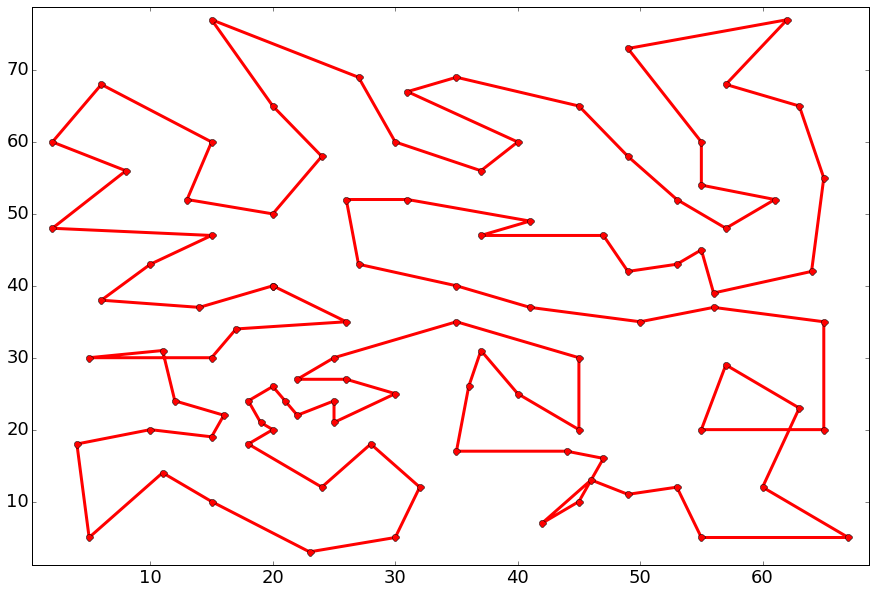

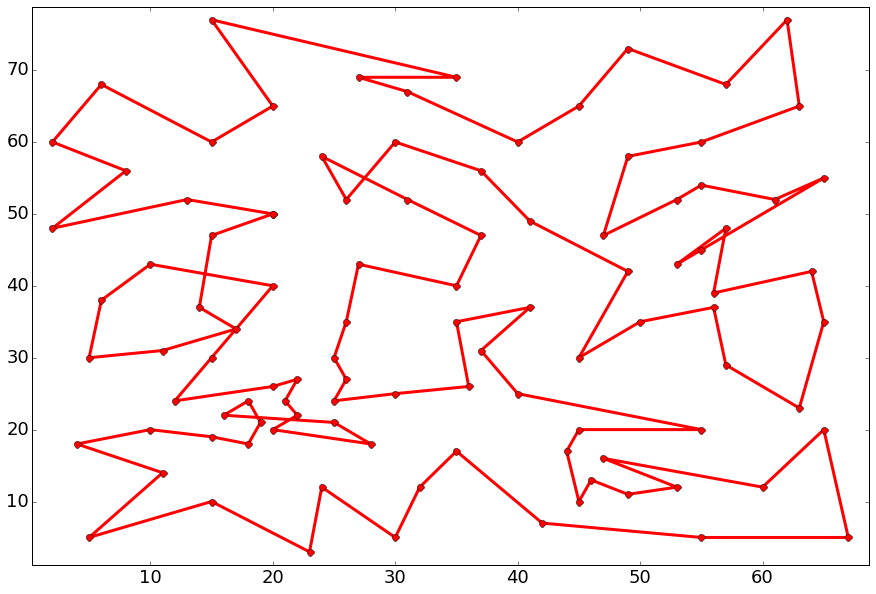

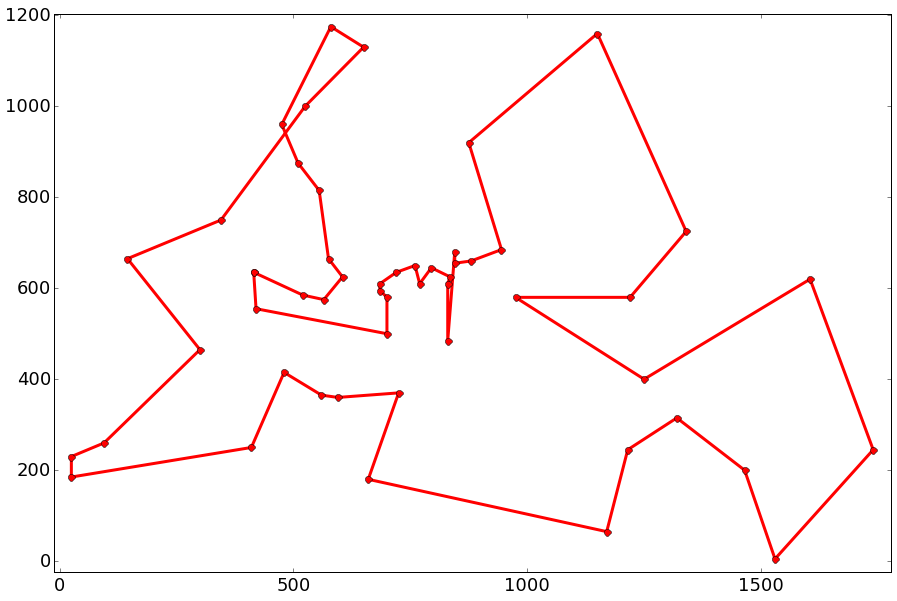

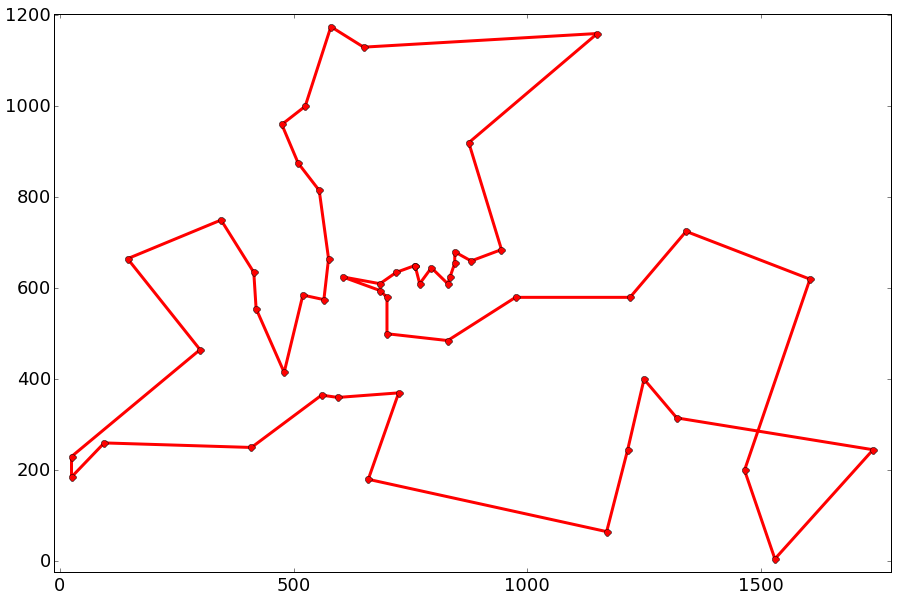

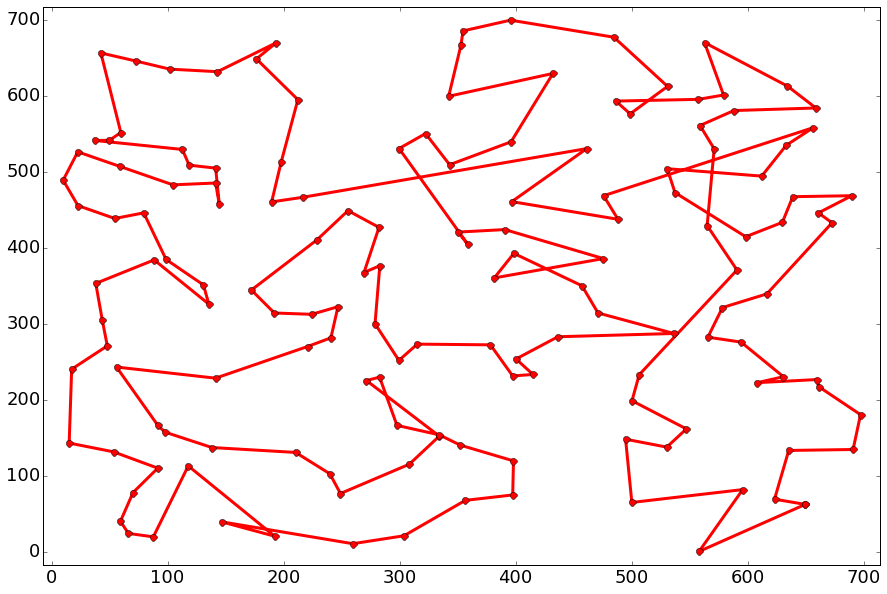

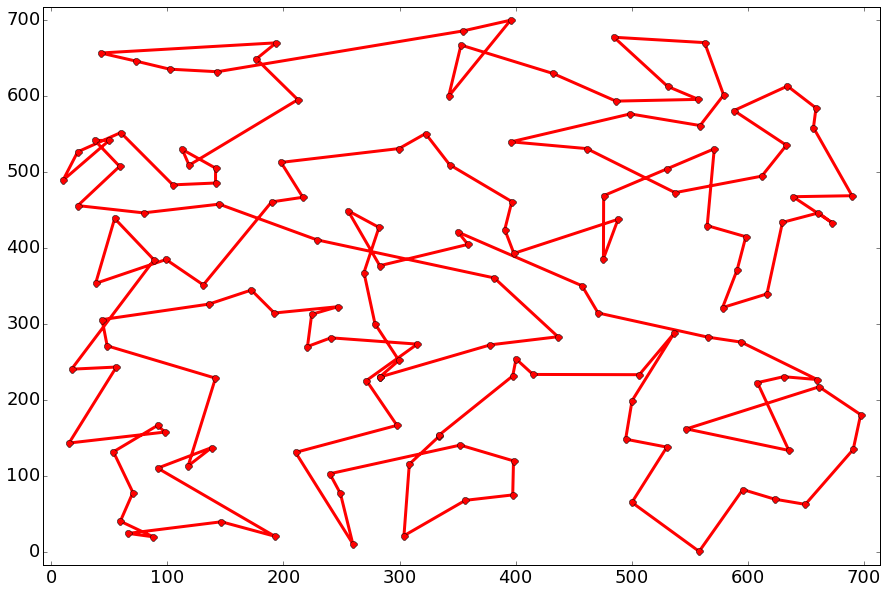

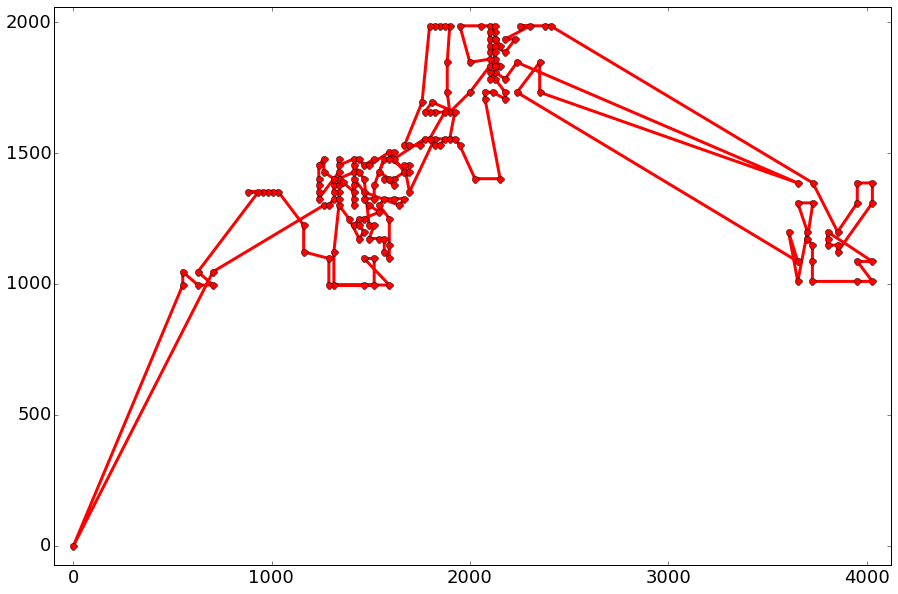

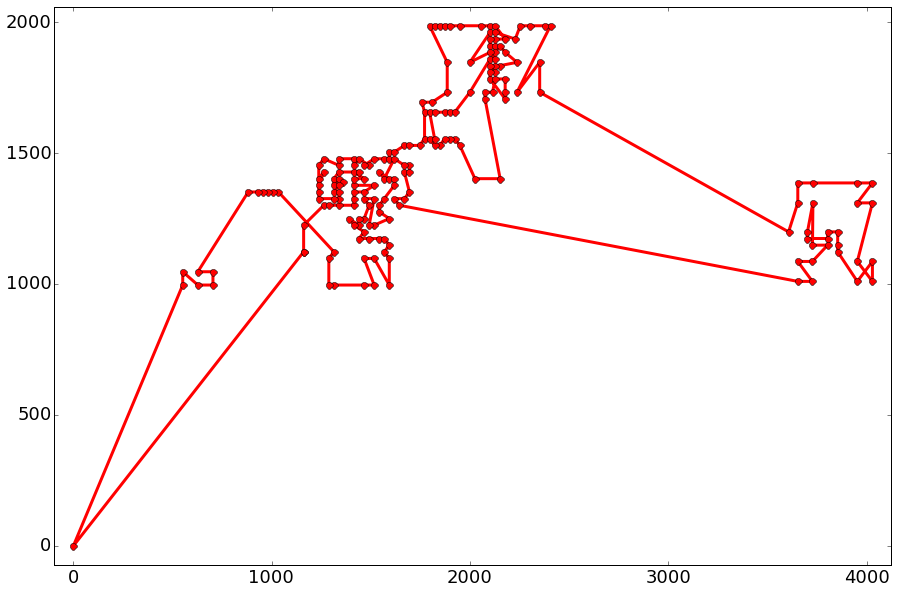

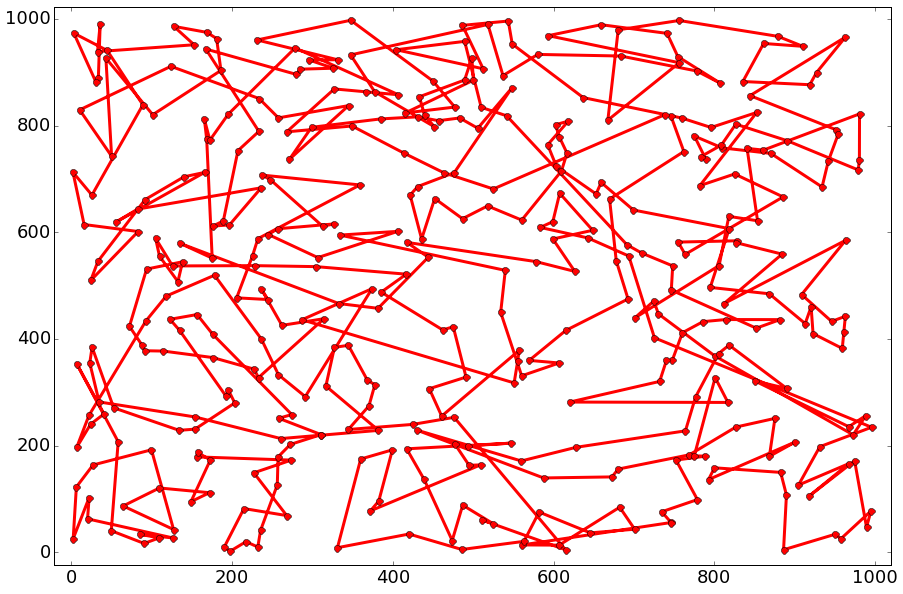

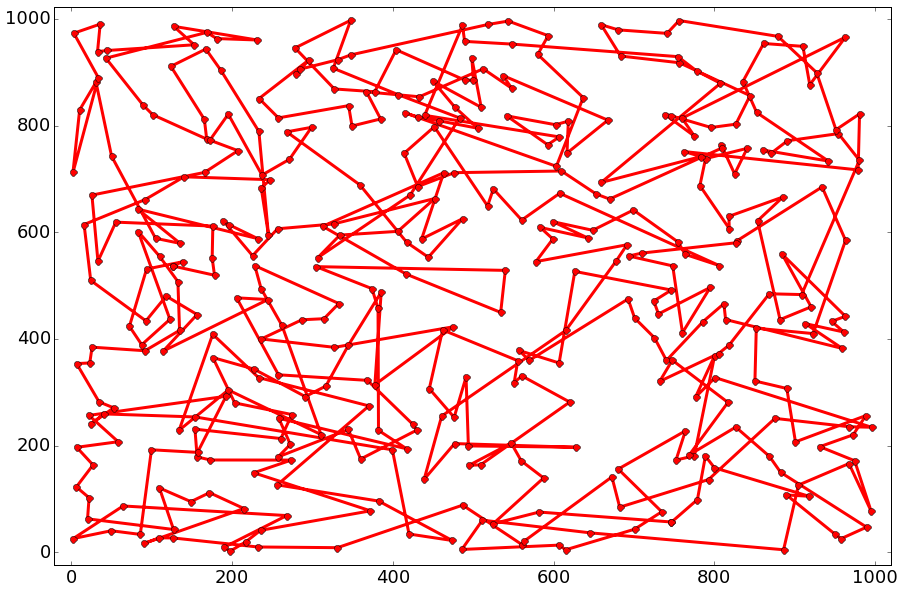

In [303]:
for name in problems:
    print (name 
           + '\n\t SA: '   + str(sa_costes[name])
           + '\n\t TS: '   + str(ts_costes[name])
           + '\n\t Best: ' + str(best_solutions[name]))
    problems[name].print_solution(sa_solutions[name])
    problems[name].print_solution(ts_solutions[name])